In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import GridWorld_env
from replay_buffer import ReplayBuffer, PrioritizedReplayBuffer

import gymnasium as gym
import random
import math
from itertools import count

device = "cuda" if torch.cuda.is_available() else "cpu"

from collections import namedtuple

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', "h", "c"))

In [2]:
class DoubleDueling_DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        
        super(DoubleDueling_DQN, self).__init__()
        self.conv1 = nn.Conv3d(3, 29, 3, 1, 1)
        self.conv2 = nn.Conv3d(32, 67, 3, 1, 1)
        
        self.fc1 = nn.Linear((64 + 3*2)*input_dim * input_dim * input_dim, 1024)
        
        self.lstmcell = nn.LSTMCell(1024, 1024)
        
        self.actions = nn.Linear(1024, action_dim)
        self.advantage = nn.Linear(1024, 1)
    def forward(self, x, h, c):
        original_state = x
                    
        x = self.conv1(x)
        x = torch.cat([x, original_state], dim=1)
        x = F.relu6(x)
        
        x = self.conv2(x)
        x = torch.cat([x, original_state], dim=1)
        x = F.relu6(x)
        
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = F.relu6(x)
        
        h, c = self.lstmcell(x, (h, c))
        
        actions = self.actions(h)
        
        x = self.advantage(h) + (actions - actions.mean(dim=1, keepdim=True))
        return x, h, c

In [3]:
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.99
EPS_END = 0.01
EPS_DECAY = 1500000
TAU = 0.0002
STEPSIZE = 0.00005
BETA_START = 0.4
BETA_END = 1
BETA_LINEAR_CAP = 5500 * 1500
N_STEP = 1


n_actions = 10
env = gym.make("GridWorld_env/GridWorld", dimension_size=4, path="targets")
env.reset()

policy_net = DoubleDueling_DQN(4, n_actions)
target_net = DoubleDueling_DQN(4, n_actions)

# if cuda avaialble, move the networks to the GPU
if torch.cuda.is_available():
    policy_net.cuda()
    target_net.cuda()
target_net.load_state_dict(policy_net.state_dict())

optimiser = optim.Adam(policy_net.parameters(), lr=STEPSIZE, eps=1.5e-4)
memory = ReplayBuffer(obs_dim=(3,4,4,4), size=32768, n_step=N_STEP, gamma = GAMMA, batch_size=BATCH_SIZE)

steps_done = 0

/home/truong/Documents/pytorch/myv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [4]:
def select_action(state, h, c, greedy = False):
    global steps_done
    
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if greedy:
        with torch.no_grad():
            out, h, c = policy_net(state, h, c)
            return out.max(1).indices.view(1,1), h, c
            #return policy_net(state, h, c).max(1).indices.view(1,1), h, c
        
    if sample > eps_threshold:
        with torch.no_grad():
            out, h, c = policy_net(state, h, c)
            return out.max(1).indices.view(1,1), h, c
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long), h, c



In [5]:
episode_durations = []


def optimise_model(beta):
    if len(memory) < 8192:
        return 0, torch.tensor([0], dtype=torch.float32)
    transitions = memory.sample_batch() 
    batch = Transition(
        torch.tensor(transitions["obs"], device=device),
        torch.tensor(transitions["acts"], device=device, dtype=torch.int64),
        torch.tensor(transitions["next_obs"], device=device),
        torch.tensor(transitions["rews"], device=device),
        transitions["h"].to(device),
        transitions["c"].to(device)
    )
    
    #indices = transitions["indices"]
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s.unsqueeze(0) for s in batch.next_state if s is not None])
    
    state_batch = batch.state
    action_batch = batch.action
    reward_batch = batch.reward
    h = batch.h
    c = batch.c
    
    tmp, _, _ = policy_net(state_batch, h, c)
    state_action_values = tmp.gather(1, action_batch.unsqueeze(1))
    next_state_values = torch.zeros(BATCH_SIZE, device = device)
    
    #double dqn
    max_a = policy_net(non_final_next_states, h, c)[0].detach().max(1).indices
    next_state_values[non_final_mask] = target_net(non_final_next_states, h, c)[0].detach().gather(1, max_a.unsqueeze(1)).squeeze(1)
    with torch.no_grad():
        expected_state_action_values = (GAMMA ** N_STEP) * next_state_values + reward_batch
    criterion = nn.MSELoss()
    
    
    loss = criterion(state_action_values , expected_state_action_values.unsqueeze(1))
    
    optimiser.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 10)
    optimiser.step()
    
    #new_priorities = torch.abs(state_action_values - expected_state_action_values.unsqueeze(1)).detach().cpu().numpy() + 1e-7 #loss.detach().cpu().numpy() + 1e-6
    return loss.item(), reward_batch.float()


reward_plot = []

In [7]:
if torch.cuda.is_available():
    num_episodes = 10000
else:
    num_episodes = 1

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    cummulative_reward = 0
    
    h = torch.zeros(1, 1024, device=device)
    c = torch.zeros(1, 1024, device=device)
    
    for t in count():
        action, h, c = select_action(state, h, c)


        observation, reward, terminated, truncated, _ = env.step((action.item(), 0))
        
        cummulative_reward += reward
        reward = torch.tensor([reward], device=device)
        
        done = terminated or truncated
        if terminated:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.store(state.cpu().numpy(), action, reward, next_state.cpu().numpy(), done, h, c)
        state = next_state

        beta = BETA_START + (BETA_END - BETA_START) * (steps_done) / BETA_LINEAR_CAP if steps_done < BETA_LINEAR_CAP else BETA_END
        l, r = optimise_model(beta)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        if done:
            episode_durations.append(t + 1)
            #plot_durations()
            break
        
    if i_episode % 1 == 0 and i_episode > 1:
        print("Episode: {0} Loss {1} Mean Sample Reward {2}:" .format(i_episode, l, r.mean().item()))
        #print(env.unwrapped.get_seqsuence())
        #env.unwrapped.render()
    
    if i_episode % 1000 == 0 and i_episode > 1:
        torch.save(policy_net, "checkpoint" + str(i_episode) + "_policy.pt")
        torch.save(target_net, "checkpoint" + str(i_episode) + "_target.pt")
        
    
    reward_plot.append(cummulative_reward)

print('Complete')
#plot_durations(show_result=True)

Complete


8


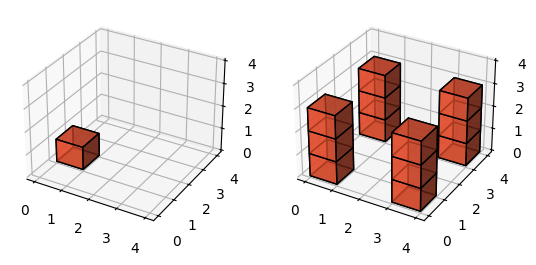

AttributeError: 'function' object has no attribute 'clear_output'

In [9]:
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
h = torch.zeros(1, 1024, dtype=torch.float32, device=device)
c = torch.zeros(1, 1024, dtype=torch.float32, device=device)

for t in count():
    
    action, h, c = select_action(state, h, c, False)
    observation, reward, terminated, truncated, _ = env.step((action.item(), 0))
    print(action.item())
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated

    if terminated:
        next_state = None
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    state = next_state
    if terminated or truncated:
        break
    env.unwrapped.render()
    #sleep(2)
    display.clear_output(wait=True)

